In [23]:
import argparse
import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, FGSM
from advertorch.attacks import LinfSPSAAttack
from src.trainers import Trainer, FGSMTrainer
from robustbench.model_zoo.models import Carmon2019UnlabeledNet
from src.utils import adversarial_accuracy, fgsm_
from src.gradient_masking_tests import gradient_norm, fgsm_pgd_cos_dif, multi_scale_fgsm
import eagerpy as ep
from src.Nets import CIFAR_Wide_Res_Net, CIFAR_Res_Net, CIFAR_Net, ResNet18GradReg
%load_ext autoreload
%autoreload 2
%aimport src.Nets, src.trainers, src.gradient_masking_tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# setup
device = torch.device("cuda")
batch_size = 128
# remove the normalize
transform = transform = transforms.Compose(
            [transforms.ToTensor()]
)
        
normalized_min = (0 - 0.5) / 0.5
normalized_max = (1 - 0.5) / 0.5
train_dataset = datasets.CIFAR10(root='../data', train=True,
                                download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=2)
test_dataset = datasets.CIFAR10(root='../data', train=False,
                               download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)
classes = classes = ('plane', 'car', 'bird', 'cat',
   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Load Regular CIFAR-10 model

In [3]:
model = CIFAR_Res_Net(device).eval()
model.load_state_dict(torch.load("../models/cifar_res_net.model"))

<All keys matched successfully>

## Load CIFAR-10 Model trained with large FGSM steps

In [7]:
fgsm_model = CIFAR_Res_Net(device).eval()
fgsm_model.load_state_dict(torch.load("../models/cifar_res_net_fgsm06.model"))

<All keys matched successfully>

## Load CIFAR-10 Step-LL Model

In [11]:
step_ll_model = CIFAR_Res_Net(device).eval()
step_ll_model.load_state_dict(torch.load("../models/cifar_res_net_20e_stepll.model"))

<All keys matched successfully>

## Load Gradient Regularized model

In [93]:
gradient_norm_model = CIFAR_Res_Net(device).eval()
state_dict = torch.load("D:/Libraries/Documents/tulip/cifar10/logs/cifar10/ResNet18/50e_1/best.pth.tar")['state_dict']
gradient_norm_model.load_state_dict(state_dict)

<All keys matched successfully>

### Check gradient norms
Gradients seem to blow up after FGSM training

In [10]:
subset_size = 5000
subset = torch.utils.data.Subset(train_dataset, np.random.randint(0, len(test_dataset), size=subset_size).tolist())
subset_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)

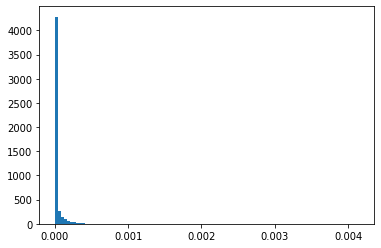

In [12]:
plt.hist(gradient_norm(model, subset_loader, device=device).detach().cpu().numpy(), bins=100)
plt.show()

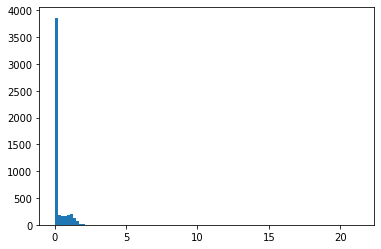

In [13]:
plt.hist(gradient_norm(fgsm_model, subset_loader, device=device).detach().cpu().numpy(), bins=100)
plt.show()

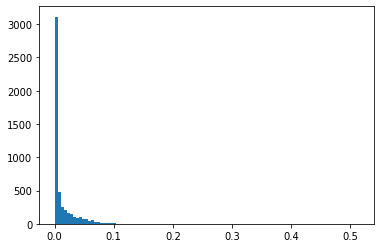

In [14]:
plt.hist(gradient_norm(gradient_norm_model, subset_loader, device=device).detach().cpu().numpy(), bins=100)
plt.show()

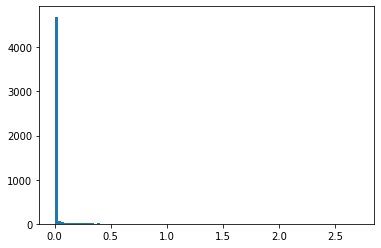

In [12]:
plt.hist(gradient_norm(step_ll_model, subset_loader, device=device).detach().cpu().numpy(), bins=100)
plt.show()

In [86]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(model, test_dataset, epsilon=0.03, device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)
cos_dif[(~success_fgsm & success_pgd)].mean(), cos_dif[success_fgsm].mean(), dist.mean()

  2%|██                                                                                 | 1/40 [00:03<02:27,  3.77s/it]

tensor(28.0673, device='cuda:0')
tensor(1.6784, device='cuda:0')


  5%|████▏                                                                              | 2/40 [00:05<02:03,  3.26s/it]

tensor(28.9442, device='cuda:0')
tensor(1.6817, device='cuda:0')


  8%|██████▏                                                                            | 3/40 [00:07<01:47,  2.90s/it]

tensor(28.8290, device='cuda:0')
tensor(1.6670, device='cuda:0')


 10%|████████▎                                                                          | 4/40 [00:09<01:35,  2.64s/it]

tensor(29.0906, device='cuda:0')
tensor(1.6669, device='cuda:0')


 12%|██████████▍                                                                        | 5/40 [00:11<01:26,  2.46s/it]

tensor(28.9253, device='cuda:0')
tensor(1.6739, device='cuda:0')


 15%|████████████▍                                                                      | 6/40 [00:14<01:20,  2.36s/it]

tensor(28.9564, device='cuda:0')
tensor(1.6820, device='cuda:0')


 18%|██████████████▌                                                                    | 7/40 [00:16<01:15,  2.30s/it]

tensor(30.7688, device='cuda:0')
tensor(1.6650, device='cuda:0')


 20%|████████████████▌                                                                  | 8/40 [00:18<01:11,  2.23s/it]

tensor(29.5517, device='cuda:0')
tensor(1.6865, device='cuda:0')


 22%|██████████████████▋                                                                | 9/40 [00:20<01:07,  2.19s/it]

tensor(28.9086, device='cuda:0')
tensor(1.6795, device='cuda:0')


 25%|████████████████████▌                                                             | 10/40 [00:22<01:04,  2.15s/it]

tensor(29.4812, device='cuda:0')
tensor(1.6775, device='cuda:0')


 28%|██████████████████████▌                                                           | 11/40 [00:24<01:02,  2.14s/it]

tensor(29.7065, device='cuda:0')
tensor(1.6857, device='cuda:0')


 30%|████████████████████████▌                                                         | 12/40 [00:26<01:00,  2.16s/it]

tensor(29.0878, device='cuda:0')
tensor(1.6706, device='cuda:0')


 32%|██████████████████████████▋                                                       | 13/40 [00:28<00:58,  2.15s/it]

tensor(30.0513, device='cuda:0')
tensor(1.6757, device='cuda:0')


 35%|████████████████████████████▋                                                     | 14/40 [00:31<00:55,  2.14s/it]

tensor(29.1166, device='cuda:0')
tensor(1.6830, device='cuda:0')


 38%|██████████████████████████████▊                                                   | 15/40 [00:33<00:54,  2.17s/it]

tensor(29.2788, device='cuda:0')
tensor(1.6679, device='cuda:0')


 40%|████████████████████████████████▊                                                 | 16/40 [00:35<00:52,  2.18s/it]

tensor(29.3526, device='cuda:0')
tensor(1.6738, device='cuda:0')


 42%|██████████████████████████████████▊                                               | 17/40 [00:37<00:49,  2.14s/it]

tensor(29.3700, device='cuda:0')
tensor(1.6643, device='cuda:0')


 45%|████████████████████████████████████▉                                             | 18/40 [00:39<00:46,  2.12s/it]

tensor(29.6458, device='cuda:0')
tensor(1.6805, device='cuda:0')


 48%|██████████████████████████████████████▉                                           | 19/40 [00:41<00:44,  2.10s/it]

tensor(28.6403, device='cuda:0')
tensor(1.6673, device='cuda:0')


 50%|█████████████████████████████████████████                                         | 20/40 [00:43<00:41,  2.09s/it]

tensor(27.5086, device='cuda:0')
tensor(1.6600, device='cuda:0')


 52%|███████████████████████████████████████████                                       | 21/40 [00:45<00:39,  2.08s/it]

tensor(28.9252, device='cuda:0')
tensor(1.6799, device='cuda:0')


 55%|█████████████████████████████████████████████                                     | 22/40 [00:47<00:37,  2.07s/it]

tensor(28.7832, device='cuda:0')
tensor(1.6799, device='cuda:0')


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:49<00:35,  2.07s/it]

tensor(28.4638, device='cuda:0')
tensor(1.6744, device='cuda:0')


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:51<00:33,  2.07s/it]

tensor(28.9597, device='cuda:0')
tensor(1.6690, device='cuda:0')


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:54<00:30,  2.06s/it]

tensor(28.3453, device='cuda:0')
tensor(1.6766, device='cuda:0')


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:56<00:28,  2.06s/it]

tensor(28.9959, device='cuda:0')
tensor(1.6729, device='cuda:0')


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:58<00:26,  2.06s/it]

tensor(27.9285, device='cuda:0')
tensor(1.6757, device='cuda:0')


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [01:00<00:24,  2.06s/it]

tensor(28.1700, device='cuda:0')
tensor(1.6660, device='cuda:0')


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [01:02<00:22,  2.06s/it]

tensor(28.8772, device='cuda:0')
tensor(1.6456, device='cuda:0')


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [01:04<00:20,  2.06s/it]

tensor(29.0735, device='cuda:0')
tensor(1.6639, device='cuda:0')


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [01:06<00:18,  2.06s/it]

tensor(29.0661, device='cuda:0')
tensor(1.6793, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [01:08<00:16,  2.06s/it]

tensor(29.6434, device='cuda:0')
tensor(1.6656, device='cuda:0')


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [01:10<00:14,  2.06s/it]

tensor(28.8116, device='cuda:0')
tensor(1.6934, device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [01:12<00:12,  2.06s/it]

tensor(29.6736, device='cuda:0')
tensor(1.6613, device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [01:14<00:10,  2.06s/it]

tensor(29.1718, device='cuda:0')
tensor(1.6714, device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:16<00:08,  2.06s/it]

tensor(29.9292, device='cuda:0')
tensor(1.6670, device='cuda:0')


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:18<00:06,  2.06s/it]

tensor(29.0330, device='cuda:0')
tensor(1.6835, device='cuda:0')


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:20<00:04,  2.06s/it]

tensor(28.3527, device='cuda:0')
tensor(1.6574, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:22<00:02,  2.06s/it]

tensor(29.1096, device='cuda:0')
tensor(1.6696, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:23<00:00,  2.08s/it]

tensor(30.7293, device='cuda:0')
tensor(1.6999, device='cuda:0')


(tensor(0.9979, device='cuda:0'),
 tensor(0.9977, device='cuda:0'),
 tensor(1.7822, device='cuda:0'))

In [87]:
success_fgsm.sum(), success_pgd.sum(), success_adjusted_fgsm.sum()

(tensor(4784, device='cuda:0'),
 tensor(5000, device='cuda:0'),
 tensor(4743, device='cuda:0'))

In [88]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(fgsm_model, test_dataset, epsilon=0.03, device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)
cos_dif[(~success_fgsm & success_pgd)].mean(), cos_dif[success_fgsm].mean(), dist.mean()

  2%|██                                                                                 | 1/40 [00:03<02:20,  3.61s/it]

tensor(29.2738, device='cuda:0')
tensor(1.6094, device='cuda:0')


  5%|████▏                                                                              | 2/40 [00:05<01:59,  3.15s/it]

tensor(29.6251, device='cuda:0')
tensor(1.6067, device='cuda:0')


  8%|██████▏                                                                            | 3/40 [00:07<01:44,  2.82s/it]

tensor(28.7435, device='cuda:0')
tensor(1.6004, device='cuda:0')


 10%|████████▎                                                                          | 4/40 [00:09<01:33,  2.59s/it]

tensor(29.1878, device='cuda:0')
tensor(1.5999, device='cuda:0')


 12%|██████████▍                                                                        | 5/40 [00:11<01:25,  2.43s/it]

tensor(28.9868, device='cuda:0')
tensor(1.6044, device='cuda:0')


 15%|████████████▍                                                                      | 6/40 [00:13<01:18,  2.32s/it]

tensor(30.3556, device='cuda:0')
tensor(1.5987, device='cuda:0')


 18%|██████████████▌                                                                    | 7/40 [00:15<01:14,  2.24s/it]

tensor(29.6803, device='cuda:0')
tensor(1.5980, device='cuda:0')


 20%|████████████████▌                                                                  | 8/40 [00:18<01:10,  2.19s/it]

tensor(28.9346, device='cuda:0')
tensor(1.6126, device='cuda:0')


 22%|██████████████████▋                                                                | 9/40 [00:20<01:06,  2.15s/it]

tensor(29.1755, device='cuda:0')
tensor(1.6032, device='cuda:0')


 25%|████████████████████▌                                                             | 10/40 [00:22<01:03,  2.12s/it]

tensor(29.0333, device='cuda:0')
tensor(1.6010, device='cuda:0')


 28%|██████████████████████▌                                                           | 11/40 [00:24<01:01,  2.11s/it]

tensor(29.8866, device='cuda:0')
tensor(1.5982, device='cuda:0')


 30%|████████████████████████▌                                                         | 12/40 [00:26<00:58,  2.09s/it]

tensor(29.9764, device='cuda:0')
tensor(1.6067, device='cuda:0')


 32%|██████████████████████████▋                                                       | 13/40 [00:28<00:56,  2.08s/it]

tensor(30.1898, device='cuda:0')
tensor(1.6164, device='cuda:0')


 35%|████████████████████████████▋                                                     | 14/40 [00:30<00:54,  2.08s/it]

tensor(28.9113, device='cuda:0')
tensor(1.6008, device='cuda:0')


 38%|██████████████████████████████▊                                                   | 15/40 [00:32<00:51,  2.07s/it]

tensor(28.3053, device='cuda:0')
tensor(1.6027, device='cuda:0')


 40%|████████████████████████████████▊                                                 | 16/40 [00:34<00:49,  2.07s/it]

tensor(28.9529, device='cuda:0')
tensor(1.6064, device='cuda:0')


 42%|██████████████████████████████████▊                                               | 17/40 [00:36<00:47,  2.07s/it]

tensor(28.9734, device='cuda:0')
tensor(1.6047, device='cuda:0')


 45%|████████████████████████████████████▉                                             | 18/40 [00:38<00:45,  2.07s/it]

tensor(29.1643, device='cuda:0')
tensor(1.5921, device='cuda:0')


 48%|██████████████████████████████████████▉                                           | 19/40 [00:40<00:43,  2.06s/it]

tensor(29.0264, device='cuda:0')
tensor(1.6115, device='cuda:0')


 50%|█████████████████████████████████████████                                         | 20/40 [00:42<00:41,  2.06s/it]

tensor(28.6741, device='cuda:0')
tensor(1.6083, device='cuda:0')


 52%|███████████████████████████████████████████                                       | 21/40 [00:44<00:39,  2.06s/it]

tensor(29.0065, device='cuda:0')
tensor(1.6032, device='cuda:0')


 55%|█████████████████████████████████████████████                                     | 22/40 [00:46<00:37,  2.06s/it]

tensor(28.9446, device='cuda:0')
tensor(1.5940, device='cuda:0')


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:48<00:35,  2.06s/it]

tensor(29.3567, device='cuda:0')
tensor(1.6002, device='cuda:0')


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:51<00:32,  2.06s/it]

tensor(28.4692, device='cuda:0')
tensor(1.6068, device='cuda:0')


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:53<00:30,  2.06s/it]

tensor(28.6360, device='cuda:0')
tensor(1.6127, device='cuda:0')


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:55<00:28,  2.06s/it]

tensor(28.8608, device='cuda:0')
tensor(1.6119, device='cuda:0')


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:57<00:26,  2.06s/it]

tensor(29.4688, device='cuda:0')
tensor(1.5997, device='cuda:0')


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:59<00:24,  2.06s/it]

tensor(29.3658, device='cuda:0')
tensor(1.6024, device='cuda:0')


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [01:01<00:23,  2.13s/it]

tensor(29.3752, device='cuda:0')
tensor(1.6018, device='cuda:0')


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [01:03<00:21,  2.16s/it]

tensor(29.0354, device='cuda:0')
tensor(1.6003, device='cuda:0')


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [01:06<00:19,  2.18s/it]

tensor(29.3861, device='cuda:0')
tensor(1.5988, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [01:08<00:17,  2.17s/it]

tensor(28.9760, device='cuda:0')
tensor(1.6051, device='cuda:0')


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [01:10<00:15,  2.16s/it]

tensor(28.5804, device='cuda:0')
tensor(1.6074, device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [01:12<00:12,  2.16s/it]

tensor(28.5716, device='cuda:0')
tensor(1.6082, device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [01:14<00:10,  2.15s/it]

tensor(28.7572, device='cuda:0')
tensor(1.6072, device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:16<00:08,  2.17s/it]

tensor(28.6140, device='cuda:0')
tensor(1.6042, device='cuda:0')


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:19<00:06,  2.18s/it]

tensor(28.8526, device='cuda:0')
tensor(1.6076, device='cuda:0')


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:21<00:04,  2.16s/it]

tensor(29.4454, device='cuda:0')
tensor(1.5971, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:23<00:02,  2.13s/it]

tensor(28.5600, device='cuda:0')
tensor(1.6068, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:23<00:00,  2.09s/it]

tensor(28.7292, device='cuda:0')
tensor(1.5793, device='cuda:0')


(tensor(0.9974, device='cuda:0'),
 tensor(0.9971, device='cuda:0'),
 tensor(1.9526, device='cuda:0'))

In [89]:
success_fgsm.sum(), success_pgd.sum(), success_adjusted_fgsm.sum()

(tensor(1306, device='cuda:0'),
 tensor(5000, device='cuda:0'),
 tensor(2807, device='cuda:0'))

In [94]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(gradient_norm_model, test_dataset, epsilon=0.03, device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)
cos_dif[(~success_fgsm & success_pgd)].mean(), cos_dif[success_fgsm].mean(), dist.mean()

  2%|██                                                                                 | 1/40 [00:03<02:31,  3.89s/it]

tensor(28.6541, device='cuda:0')
tensor(1.6748, device='cuda:0')


  5%|████▏                                                                              | 2/40 [00:06<02:07,  3.37s/it]

tensor(27.9016, device='cuda:0')
tensor(1.6726, device='cuda:0')


  8%|██████▏                                                                            | 3/40 [00:08<01:50,  3.00s/it]

tensor(29.1668, device='cuda:0')
tensor(1.6603, device='cuda:0')


 10%|████████▎                                                                          | 4/40 [00:10<01:38,  2.74s/it]

tensor(29.8555, device='cuda:0')
tensor(1.6660, device='cuda:0')


 12%|██████████▍                                                                        | 5/40 [00:12<01:29,  2.56s/it]

tensor(28.9882, device='cuda:0')
tensor(1.6900, device='cuda:0')


 15%|████████████▍                                                                      | 6/40 [00:14<01:22,  2.44s/it]

tensor(29.9319, device='cuda:0')
tensor(1.6646, device='cuda:0')


 18%|██████████████▌                                                                    | 7/40 [00:16<01:17,  2.35s/it]

tensor(29.8531, device='cuda:0')
tensor(1.6831, device='cuda:0')


 20%|████████████████▌                                                                  | 8/40 [00:18<01:13,  2.29s/it]

tensor(29.0313, device='cuda:0')
tensor(1.6821, device='cuda:0')


 22%|██████████████████▋                                                                | 9/40 [00:21<01:09,  2.24s/it]

tensor(29.4213, device='cuda:0')
tensor(1.6511, device='cuda:0')


 25%|████████████████████▌                                                             | 10/40 [00:23<01:06,  2.21s/it]

tensor(29.7156, device='cuda:0')
tensor(1.6743, device='cuda:0')


 28%|██████████████████████▌                                                           | 11/40 [00:25<01:03,  2.19s/it]

tensor(28.1940, device='cuda:0')
tensor(1.6864, device='cuda:0')


 30%|████████████████████████▌                                                         | 12/40 [00:27<01:00,  2.18s/it]

tensor(29.2761, device='cuda:0')
tensor(1.6556, device='cuda:0')


 32%|██████████████████████████▋                                                       | 13/40 [00:29<00:58,  2.17s/it]

tensor(29.3915, device='cuda:0')
tensor(1.6956, device='cuda:0')


 35%|████████████████████████████▋                                                     | 14/40 [00:31<00:56,  2.16s/it]

tensor(29.3546, device='cuda:0')
tensor(1.6802, device='cuda:0')


 38%|██████████████████████████████▊                                                   | 15/40 [00:33<00:53,  2.16s/it]

tensor(28.8046, device='cuda:0')
tensor(1.6784, device='cuda:0')


 40%|████████████████████████████████▊                                                 | 16/40 [00:36<00:51,  2.15s/it]

tensor(29.2095, device='cuda:0')
tensor(1.6795, device='cuda:0')


 42%|██████████████████████████████████▊                                               | 17/40 [00:38<00:49,  2.15s/it]

tensor(29.5914, device='cuda:0')
tensor(1.6736, device='cuda:0')


 45%|████████████████████████████████████▉                                             | 18/40 [00:40<00:47,  2.16s/it]

tensor(29.1262, device='cuda:0')
tensor(1.6365, device='cuda:0')


 48%|██████████████████████████████████████▉                                           | 19/40 [00:42<00:45,  2.16s/it]

tensor(28.5707, device='cuda:0')
tensor(1.6812, device='cuda:0')


 50%|█████████████████████████████████████████                                         | 20/40 [00:44<00:43,  2.16s/it]

tensor(28.0570, device='cuda:0')
tensor(1.6853, device='cuda:0')


 52%|███████████████████████████████████████████                                       | 21/40 [00:46<00:40,  2.16s/it]

tensor(29.0408, device='cuda:0')
tensor(1.6901, device='cuda:0')


 55%|█████████████████████████████████████████████                                     | 22/40 [00:48<00:38,  2.15s/it]

tensor(29.6683, device='cuda:0')
tensor(1.6771, device='cuda:0')


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:51<00:36,  2.15s/it]

tensor(29.5140, device='cuda:0')
tensor(1.7130, device='cuda:0')


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:53<00:34,  2.15s/it]

tensor(29.2555, device='cuda:0')
tensor(1.6784, device='cuda:0')


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:55<00:32,  2.15s/it]

tensor(29.4111, device='cuda:0')
tensor(1.6707, device='cuda:0')


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:57<00:30,  2.15s/it]

tensor(28.9446, device='cuda:0')
tensor(1.6634, device='cuda:0')


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:59<00:27,  2.15s/it]

tensor(28.4752, device='cuda:0')
tensor(1.6779, device='cuda:0')


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [01:01<00:25,  2.15s/it]

tensor(28.4428, device='cuda:0')
tensor(1.6866, device='cuda:0')


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [01:03<00:23,  2.15s/it]

tensor(28.5869, device='cuda:0')
tensor(1.6878, device='cuda:0')


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [01:06<00:21,  2.15s/it]

tensor(28.0585, device='cuda:0')
tensor(1.7006, device='cuda:0')


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [01:08<00:19,  2.14s/it]

tensor(29.6606, device='cuda:0')
tensor(1.6742, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [01:10<00:17,  2.14s/it]

tensor(28.7885, device='cuda:0')
tensor(1.6839, device='cuda:0')


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [01:12<00:15,  2.14s/it]

tensor(28.6854, device='cuda:0')
tensor(1.6929, device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [01:14<00:12,  2.15s/it]

tensor(29.0421, device='cuda:0')
tensor(1.6987, device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [01:16<00:10,  2.15s/it]

tensor(29.9814, device='cuda:0')
tensor(1.6829, device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:19<00:08,  2.15s/it]

tensor(29.7612, device='cuda:0')
tensor(1.6683, device='cuda:0')


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:21<00:06,  2.15s/it]

tensor(28.6935, device='cuda:0')
tensor(1.6608, device='cuda:0')


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:23<00:04,  2.14s/it]

tensor(29.1053, device='cuda:0')
tensor(1.6763, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:25<00:02,  2.15s/it]

tensor(28.6684, device='cuda:0')
tensor(1.6931, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:25<00:00,  2.15s/it]

tensor(31.5351, device='cuda:0')
tensor(1.6010, device='cuda:0')


(tensor(0.9981, device='cuda:0'),
 tensor(0.9978, device='cuda:0'),
 tensor(1.7357, device='cuda:0'))

In [95]:
success_fgsm.sum(), success_pgd.sum(), success_adjusted_fgsm.sum()

(tensor(4421, device='cuda:0'),
 tensor(4968, device='cuda:0'),
 tensor(4348, device='cuda:0'))

In [91]:
cos_dif, dist, success_fgsm, success_pgd, success_adjusted_fgsm = fgsm_pgd_cos_dif(step_ll_model, train_dataset, epsilon=0.03, device=device, batch_size=batch_size, subset_size=5000, n_steps_pgd=20)
cos_dif[(~success_fgsm & success_pgd)].mean(), cos_dif[success_fgsm].mean(), dist.mean()

  2%|██                                                                                 | 1/40 [00:05<03:42,  5.70s/it]

tensor(29.2623, device='cuda:0')
tensor(1.6322, device='cuda:0')


  5%|████▏                                                                              | 2/40 [00:07<02:55,  4.62s/it]

tensor(29.2677, device='cuda:0')
tensor(1.6576, device='cuda:0')


  8%|██████▏                                                                            | 3/40 [00:09<02:22,  3.85s/it]

tensor(28.9635, device='cuda:0')
tensor(1.6578, device='cuda:0')


 10%|████████▎                                                                          | 4/40 [00:11<01:59,  3.32s/it]

tensor(29.5341, device='cuda:0')
tensor(1.6378, device='cuda:0')


 12%|██████████▍                                                                        | 5/40 [00:13<01:43,  2.94s/it]

tensor(29.1425, device='cuda:0')
tensor(1.6542, device='cuda:0')


 15%|████████████▍                                                                      | 6/40 [00:16<01:31,  2.70s/it]

tensor(29.4819, device='cuda:0')
tensor(1.6384, device='cuda:0')


 18%|██████████████▌                                                                    | 7/40 [00:18<01:24,  2.57s/it]

tensor(29.9933, device='cuda:0')
tensor(1.6413, device='cuda:0')


 20%|████████████████▌                                                                  | 8/40 [00:20<01:18,  2.45s/it]

tensor(28.6969, device='cuda:0')
tensor(1.6346, device='cuda:0')


 22%|██████████████████▋                                                                | 9/40 [00:22<01:13,  2.38s/it]

tensor(28.6800, device='cuda:0')
tensor(1.6545, device='cuda:0')


 25%|████████████████████▌                                                             | 10/40 [00:25<01:10,  2.35s/it]

tensor(29.1811, device='cuda:0')
tensor(1.6380, device='cuda:0')


 28%|██████████████████████▌                                                           | 11/40 [00:27<01:06,  2.30s/it]

tensor(28.4876, device='cuda:0')
tensor(1.6368, device='cuda:0')


 30%|████████████████████████▌                                                         | 12/40 [00:29<01:03,  2.27s/it]

tensor(29.3704, device='cuda:0')
tensor(1.6200, device='cuda:0')


 32%|██████████████████████████▋                                                       | 13/40 [00:31<01:00,  2.23s/it]

tensor(29.4192, device='cuda:0')
tensor(1.6562, device='cuda:0')


 35%|████████████████████████████▋                                                     | 14/40 [00:33<00:57,  2.20s/it]

tensor(28.9740, device='cuda:0')
tensor(1.6501, device='cuda:0')


 38%|██████████████████████████████▊                                                   | 15/40 [00:35<00:54,  2.19s/it]

tensor(29.6469, device='cuda:0')
tensor(1.6430, device='cuda:0')


 40%|████████████████████████████████▊                                                 | 16/40 [00:38<00:52,  2.17s/it]

tensor(29.1214, device='cuda:0')
tensor(1.6611, device='cuda:0')


 42%|██████████████████████████████████▊                                               | 17/40 [00:40<00:49,  2.17s/it]

tensor(28.5658, device='cuda:0')
tensor(1.6573, device='cuda:0')


 45%|████████████████████████████████████▉                                             | 18/40 [00:42<00:47,  2.16s/it]

tensor(28.9120, device='cuda:0')
tensor(1.6247, device='cuda:0')


 48%|██████████████████████████████████████▉                                           | 19/40 [00:44<00:45,  2.15s/it]

tensor(28.8473, device='cuda:0')
tensor(1.6382, device='cuda:0')


 50%|█████████████████████████████████████████                                         | 20/40 [00:46<00:43,  2.15s/it]

tensor(28.8882, device='cuda:0')
tensor(1.6462, device='cuda:0')


 52%|███████████████████████████████████████████                                       | 21/40 [00:48<00:40,  2.15s/it]

tensor(29.7442, device='cuda:0')
tensor(1.6482, device='cuda:0')


 55%|█████████████████████████████████████████████                                     | 22/40 [00:50<00:38,  2.15s/it]

tensor(29.5331, device='cuda:0')
tensor(1.6533, device='cuda:0')


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:53<00:36,  2.15s/it]

tensor(28.4666, device='cuda:0')
tensor(1.6492, device='cuda:0')


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:55<00:34,  2.15s/it]

tensor(29.2875, device='cuda:0')
tensor(1.6448, device='cuda:0')


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:57<00:32,  2.15s/it]

tensor(29.4666, device='cuda:0')
tensor(1.6447, device='cuda:0')


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:59<00:30,  2.17s/it]

tensor(29.3837, device='cuda:0')
tensor(1.6486, device='cuda:0')


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [01:01<00:28,  2.19s/it]

tensor(29.0775, device='cuda:0')
tensor(1.6362, device='cuda:0')


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [01:04<00:26,  2.21s/it]

tensor(28.0572, device='cuda:0')
tensor(1.6373, device='cuda:0')


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [01:06<00:24,  2.25s/it]

tensor(28.6996, device='cuda:0')
tensor(1.6378, device='cuda:0')


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [01:08<00:22,  2.25s/it]

tensor(28.9274, device='cuda:0')
tensor(1.6494, device='cuda:0')


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [01:10<00:20,  2.25s/it]

tensor(29.1169, device='cuda:0')
tensor(1.6352, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [01:13<00:17,  2.24s/it]

tensor(29.0640, device='cuda:0')
tensor(1.6347, device='cuda:0')


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [01:15<00:15,  2.22s/it]

tensor(29.5770, device='cuda:0')
tensor(1.6389, device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [01:17<00:13,  2.21s/it]

tensor(30.1269, device='cuda:0')
tensor(1.6537, device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [01:19<00:10,  2.19s/it]

tensor(27.4286, device='cuda:0')
tensor(1.6458, device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:21<00:08,  2.18s/it]

tensor(29.0522, device='cuda:0')
tensor(1.6483, device='cuda:0')


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:23<00:06,  2.17s/it]

tensor(28.7024, device='cuda:0')
tensor(1.6300, device='cuda:0')


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:26<00:04,  2.16s/it]

tensor(28.6869, device='cuda:0')
tensor(1.6464, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:28<00:02,  2.16s/it]

tensor(29.3399, device='cuda:0')
tensor(1.6467, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:28<00:00,  2.22s/it]

tensor(28.9370, device='cuda:0')
tensor(1.6185, device='cuda:0')


(tensor(0.9974, device='cuda:0'),
 tensor(0.9974, device='cuda:0'),
 tensor(1.8607, device='cuda:0'))

In [92]:
success_fgsm.sum(), success_pgd.sum(), success_adjusted_fgsm.sum()

(tensor(30, device='cuda:0'),
 tensor(4413, device='cuda:0'),
 tensor(105, device='cuda:0'))